### Importing the data with provided details for the categories and the class counts

In [1]:
import os

def count_images_in_folders(directory):
    for root, dirs, files in os.walk(directory):
        image_count = 0
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_count += 1
        print(f"Folder '{os.path.relpath(root, directory)}' contains {image_count} images.")

# Replace 'directory_path' with the path to your directory
count_images_in_folders('train')

Folder '.' contains 0 images.
Folder 'anger' contains 2466 images.
Folder 'happiness' contains 7528 images.
Folder 'neutral' contains 10308 images.
Folder 'sadness' contains 3514 images.
Folder 'startle' contains 4214 images.


### Visualizing 5 image from each category

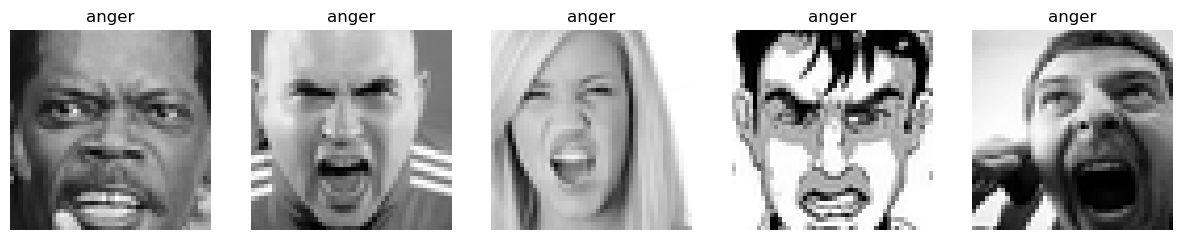

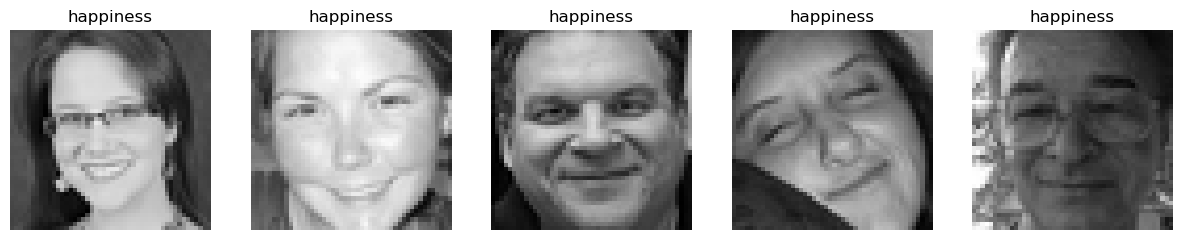

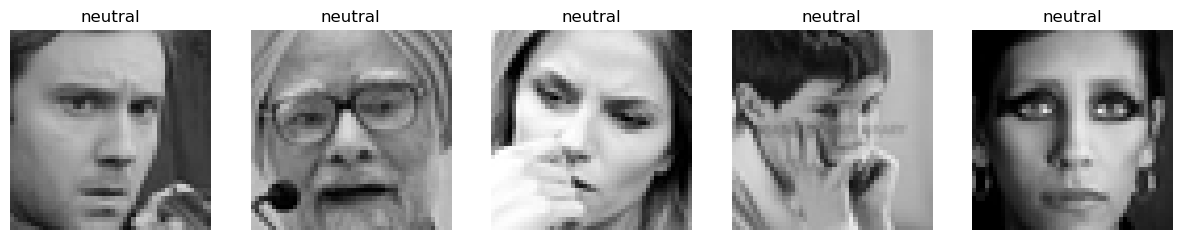

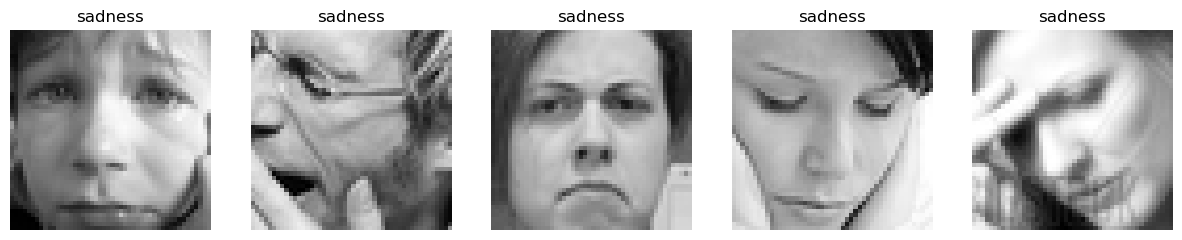

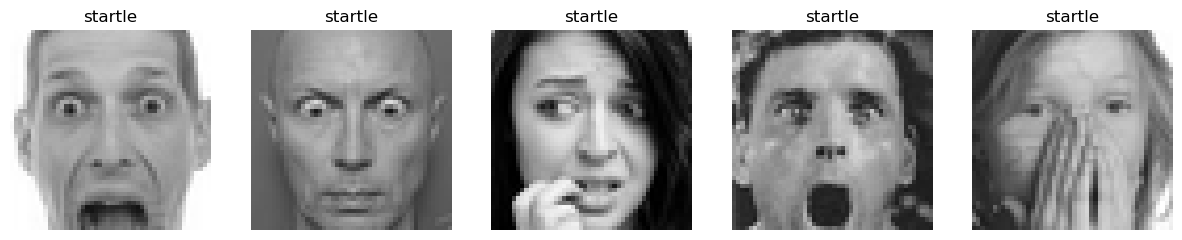

In [2]:
import matplotlib.pyplot as plt
from PIL import Image

def display_images_from_folder(folder_path, category_name, num_images=5):
    images = os.listdir(folder_path)
    images = [img for img in images if img.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        img_path = os.path.join(folder_path, images[i])
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(category_name)
    plt.show()

categories = {
    'anger': 5,
    'happiness': 5,
    'neutral': 5,
    'sadness': 5,
    'startle': 5
}

directory_path = 'train'

for category, num_images in categories.items():
    folder_path = os.path.join(directory_path, category)
    display_images_from_folder(folder_path, category, num_images)

## Data Aumgentation

In [3]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, save_img

In [4]:
# Original directories
categories_to_augment = ['anger', 'sadness', 'startle']
input_base_dir = 'train'

# Output directory for augmented data
output_base_dir = 'augmented train'

for category in categories_to_augment:
    output_dir = os.path.join(output_base_dir, category)

In [5]:
# ImageDataGenerator for augmentation
augment_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to augment images
def augment_images(input_dir, output_dir, augment_datagen, target_count):
    images = os.listdir(input_dir)
    total_images = len(images)
    num_augmented_images = target_count - total_images

    if num_augmented_images <= 0:
        print(f"Category {input_dir} already has {total_images} images, no augmentation needed.")
        return

    print(f"Augmenting {input_dir} to reach {target_count} images.")
    aug_count = 0

    # Iterate through images and augment them
    while aug_count < num_augmented_images:
        for img_name in images:
            if aug_count >= num_augmented_images:
                break

            img_path = os.path.join(input_dir, img_name)
            img = load_img(img_path)
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)
            
            # Create augmented images
            for batch in augment_datagen.flow(img_array, batch_size=1, save_to_dir=output_dir, save_prefix='aug', save_format='jpeg'):
                aug_count += 1
                if aug_count >= num_augmented_images:
                    break

# Desired number of images per category
desired_count = 10308  # Same as the 'neutral' category

for category in categories_to_augment:
    input_dir = os.path.join(input_base_dir, category)
    output_dir = os.path.join(output_base_dir, category)
    augment_images(input_dir, output_dir, augment_datagen, desired_count)

# Verify the number of images in each category
for category in categories_to_augment:
    output_dir = os.path.join(output_base_dir, category)
    print(f"Total images in {category} after augmentation: {len(os.listdir(output_dir))}")

Augmenting train\anger to reach 10308 images.
Augmenting train\sadness to reach 10308 images.
Augmenting train\startle to reach 10308 images.
Total images in anger after augmentation: 7872
Total images in sadness after augmentation: 8419
Total images in startle after augmentation: 8793


In [6]:
# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15  # Splitting 15% of data for validation
)

In [7]:
# Flow training images in batches of 64 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    output_base_dir,  # Path to the augmented training data
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    subset='training'  # Specify subset as training
)

# Flow validation images in batches of 64 using train_datagen generator
validation_generator = train_datagen.flow_from_directory(
    output_base_dir,  # Path to the augmented training data
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    subset='validation'  # Specify subset as validation
)

Found 36485 images belonging to 5 classes.
Found 6435 images belonging to 5 classes.


In [8]:
# Print class indices
print("Class indices in train_generator:", train_generator.class_indices)
print("Class indices in validation_generator:", validation_generator.class_indices)

Class indices in train_generator: {'anger': 0, 'happiness': 1, 'neutral': 2, 'sadness': 3, 'startle': 4}
Class indices in validation_generator: {'anger': 0, 'happiness': 1, 'neutral': 2, 'sadness': 3, 'startle': 4}


In [9]:
from collections import Counter

# Count the number of samples per class in the training generator
train_class_counts = Counter(train_generator.classes)
print("Class counts in train_generator:", train_class_counts)

# Count the number of samples per class in the validation generator
validation_class_counts = Counter(validation_generator.classes)
print("Class counts in validation_generator:", validation_class_counts)

Class counts in train_generator: Counter({2: 8762, 4: 7475, 3: 7157, 0: 6692, 1: 6399})
Class counts in validation_generator: Counter({2: 1546, 4: 1318, 3: 1262, 0: 1180, 1: 1129})


# Training

In [10]:
from keras.applications import ResNet50
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.regularizers import l2

In [11]:
base_model = ResNet50(weights='imagenet', include_top=False)

# Modify the input shape of the first layer to accept grayscale images
new_input = Input(shape=(48, 48, 3))  # Keep the input shape to accept three channels directly
output = base_model(new_input)  # Pass the input directly to the base model

In [12]:
# Add dropout regularization
x = GlobalAveragePooling2D()(output)
x = Dropout(0.5)(x)

# Add dense layer with L2 regularization
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)

# Output layer with L2 regularization
predictions = Dense(5, activation='softmax', kernel_regularizer=l2(0.01))(x)

# Create the model
model = Model(inputs=new_input, outputs=predictions)

In [13]:
for layer in model.layers:
    layer.trainable = False

# Optionally unfreeze all layers for fine-tuning
for layer in model.layers[-10:]:
    layer.trainable = True

In [14]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001, clipvalue=5), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 5)                 5125  

In [17]:
# Define the callback
checkpoint_callback = ModelCheckpoint(
    filepath='model_weights_num2.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1)

history = model.fit_generator(train_generator,
                             steps_per_epoch= train_generator.samples // 64,
                             epochs= 5,
                             validation_data= validation_generator,
                             validation_steps= validation_generator.samples // 64,
                             callbacks= [checkpoint_callback]
                   )

Epoch 1/5


C:\Users\POGBA\AppData\Local\Temp\ipykernel_27156\1229355461.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator,


570/570 [==============================] - ETA: 0s - loss: 10.1128 - accuracy: 0.6892
Epoch 1: val_accuracy improved from -inf to 0.27391, saving model to model_weights_num2.h5
570/570 [==============================] - 852s 1s/step - loss: 10.1128 - accuracy: 0.6892 - val_loss: 58.9843 - val_accuracy: 0.2739
Epoch 2/5
570/570 [==============================] - ETA: 0s - loss: 3.4307 - accuracy: 0.8161
Epoch 2: val_accuracy improved from 0.27391 to 0.92609, saving model to model_weights_num2.h5
570/570 [==============================] - 807s 1s/step - loss: 3.4307 - accuracy: 0.8161 - val_loss: 1.6762 - val_accuracy: 0.9261
Epoch 3/5
570/570 [==============================] - ETA: 0s - loss: 1.1970 - accuracy: 0.8710
Epoch 3: val_accuracy did not improve from 0.92609
570/570 [==============================] - 806s 1s/step - loss: 1.1970 - accuracy: 0.8710 - val_loss: 0.6951 - val_accuracy: 0.9130
Epoch 4/5
570/570 [==============================] - ETA: 0s - loss: 0.5261 - accuracy: 0.

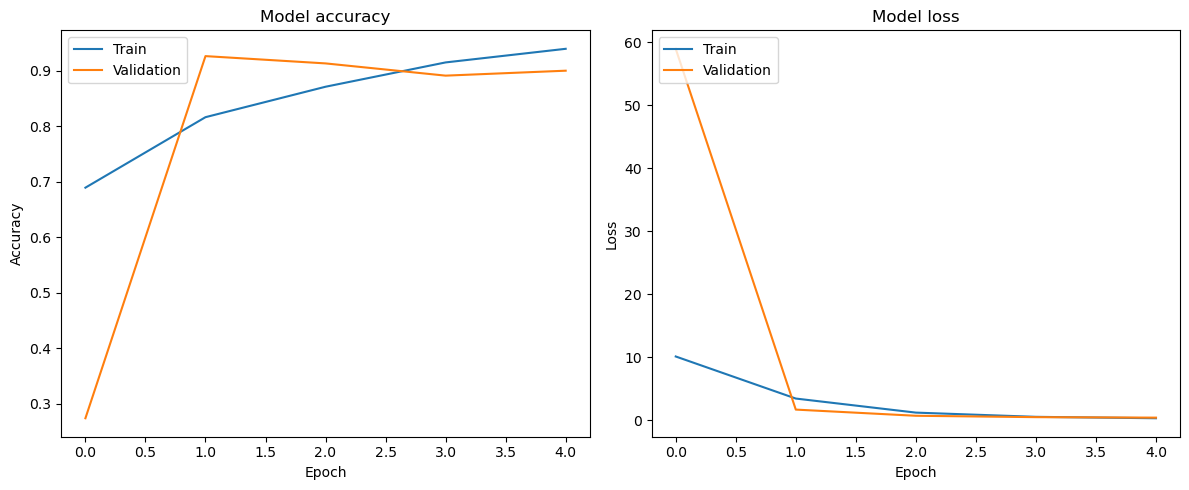

In [18]:
# Create subplots with 1 row and 2 columns
plt.figure(figsize=(12, 5))

# Plot accuracy subplot
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss subplot
plt.subplot(1, 2, 2)  # (rows, columns, index)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

101/101 [==============================] - 17s 156ms/step


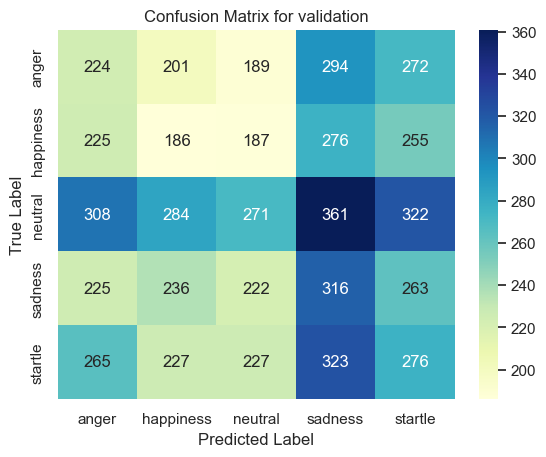

In [19]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the test set
validation_labels = validation_generator.classes
validation_pred_probs = model.predict(validation_generator)
validation_pred_labels = np.argmax(validation_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(validation_labels, validation_pred_labels)
class_names = list(validation_generator.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for validation')
plt.show()

In [20]:
test_datagen = ImageDataGenerator(rescale = 1/255)

test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='rgb'  # Ensure that input is in RGB format
)

Found 6991 images belonging to 5 classes.


In [21]:
test_generator.class_indices

{'anger': 0, 'happiness': 1, 'neutral': 2, 'sadness': 3, 'startle': 4}

In [22]:
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test Loss =',test_loss)
print('Test Accuracy =',test_accuracy)

110/110 [==============================] - 66s 600ms/step - loss: 0.9567 - accuracy: 0.7410
Test Loss = 0.9567341208457947
Test Accuracy = 0.7409526705741882


110/110 [==============================] - 17s 152ms/step


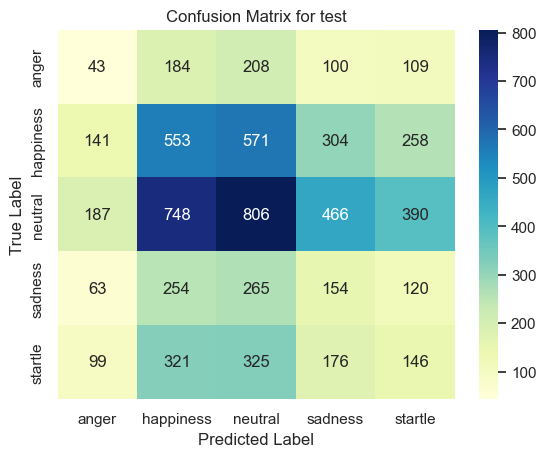

In [23]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the test set
test_labels = test_generator.classes
test_pred_probs = model.predict(test_generator)
test_pred_labels = np.argmax(test_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(test_labels, test_pred_labels)
class_names = list(test_generator.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for test')
plt.show()

In [24]:
model_json = model.to_json()
with open('best_model_num2.json', 'w') as json_file:
    json_file.write(model_json)